In [1]:
%cd /content/drive/MyDrive

[Errno 2] No such file or directory: '/content/drive/MyDrive'
/home/ajay/major-part1/Interpolate-20210906T024038Z-001/Interpolate


In [2]:
# !pip install torch==1.8.1
!pip install gpytorch

You should consider upgrading via the '/home/ajay/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
### libraries and modules
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import pandas as pd
import numpy as np
import os
import copy
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
import pickle
import gpytorch.settings as sett
from torch.optim.lr_scheduler import MultiStepLR
print(torch.__version__)

1.9.0+cu102


In [4]:
def get_kernel(kernel = 0, ard = None):
    """
    Returns the kernel according to the index given as an argument
    Ard here allows us to fit a separate lengthscale to each dimension/features. Lengthscale is one of the hyperparameters that 
    learn for the kernel function.
    """
    if kernel == 0:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = ard))
    elif kernel == 1:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, ard_num_dims = ard))
    elif kernel == 2:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5, ard_num_dims = ard))
    elif kernel == 3:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 2.5, ard_num_dims = ard))
    elif kernel == 4:
        k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [0]))
        k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, active_dims = [0,1,2]))
        return gpytorch.kernels.ProductKernel(k1, k2)
    elif kernel == 5:
        k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [0]))
        k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5, active_dims = [1,2]))
        return gpytorch.kernels.AdditiveKernel(k1, k2)
    elif kernel == 6:
        k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [0]))
        k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, active_dims = [0,1,2], ard_num_dims = 3))
        return gpytorch.kernels.AdditiveKernel(k1, k2)

def get_mean(mean = 0, n_features = 0):
    """
    Returns the mean function according to the index given as an argument
    """
    if mean == 0:
        return gpytorch.means.ConstantMean()
    elif mean == 1:
        return gpytorch.means.LinearMean(n_features)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel = 0, mean = 0, ard = None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = get_mean(mean = mean, n_features = train_x.shape[1])
        self.covar_module = get_kernel(kernel, ard = ard)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def evaluate(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return(mean_x)     
# ------------------------------------------------------
# helper functions
def create_loaders(t_tuple):
    """
    Creates dataloaders to load in minibatches during training and testing
    """
    x, y = t_tuple
    dataset = TensorDataset(x, y)
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    
    return loader

def m_s_adjust(x):
    """
    Adjusts for mean and std for input/output normalization. Used in the next function.
    
    || INPUT ||
    x - dataset to standardize 
    
    || OUTPUT ||
    x - transformed dataset
    mx - mean of original dataset
    sx - std of original dataset
    """
    x = x.clone()
    mx = x.mean(0, keepdim=True)
    sx = x.std(0, unbiased=False, keepdim=True)
    x -= mx
    x /= sx
    return x, mx, sx

def normalize(train_tuple, test_tuple = None, ms = None):
    """
    Normalize the train and/or test datasets
    
    || INPUT ||
    train_tuple - (train features, train output variable) 
    test_tuple - (test features, test output variable) 
    
    || OUTPUT ||
    outputs transformed train and test tuples (tuples as defined above) along with learnt mean and std. deviations
    """
    train_x, train_y = train_tuple
    train_x, train_y  = train_x.clone(), train_y.clone() 
    
    if ms == None:
        train_x, mx, sx = m_s_adjust(train_x)
        train_y, my, sy = m_s_adjust(train_y)
        train_tuple = (train_x, train_y)
        
        if test_tuple:
            test_x, test_y = test_tuple
            test_x, test_y  = test_x.clone(), test_y.clone() 
            test_x -= mx
            test_x /= sx
            test_y -= my
            test_y /= sy
            test_tuple = (test_x, test_y)
        else:
            test_tuple = None
    else:
        ms_x, ms_y = ms
        mx, sx = ms_x
        my, sy = ms_y
        train_x, train_y  = train_x.clone(), train_y.clone() 
        train_x -= mx
        train_x /= sx
        train_y -= my
        train_y /= sy
        train_tuple = (train_x, train_y)
        test_tuple = None
  
    return train_tuple, test_tuple, (mx, sx), (my, sy)

def keep_best(prev_train, prev_test, train_rmse, test_rmse):
    """
    This function helps us keep the best model learnt till now. It checks how current train and test rmse are compared to 
    previous iterations train and test rmse. Returns True if both are lower than previous.  
    """
    if train_rmse <= prev_train:
        if test_rmse <= prev_test:
            result = True
        else:
            result = False
    else:
        result = False
    return result
    
def train_gp(model, likelihood, y_ms, optimizer, mll, train_tuple, test_tuple, train_original_tuple = None , n_epochs = 10, cuda = False, downsize_bool = False):
    """
    Trains the Gaussian Process model
     
    || INPUT ||
    model - model to be used
    train_tuple - (train features, train output variable) 
    optimizer, mll - optimizer to be used, marginal log likelihood
    n_epochs - Number of training iterations
    cuda - whether to use GPU or not
    """
    lr_sched = MultiStepLR(optimizer, milestones = [200, 1500], gamma = 0.5)
    model.train()
    likelihood.train()
    train_x, train_y = train_tuple
    
    best_train = np.inf 
    best_test = np.inf
    best_model = None
    best_likelihood = None
    epoch_iter = tqdm.tqdm_notebook(range(n_epochs), desc="Epochs", leave=False)
    stop = 0
    for i in epoch_iter:
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
        train_rmse, train_preds = evaluate(model, likelihood, train_tuple, y_ms, cuda)
        test_rmse, test_preds = evaluate(model, likelihood, test_tuple, y_ms, cuda)
        model_best = keep_best(best_train, best_test, train_rmse, test_rmse)
        if model_best:
            best_model = copy.deepcopy(model)
            best_likelihood = copy.deepcopy(likelihood)
            best_train = train_rmse
            best_test = test_rmse
            stop = 0
        else:
            stop +=1
        if cuda:
            torch.cuda.empty_cache()
        if (i % 10 == 0):
            print("Stop: ", stop)
            print("\n|| EPOCH : ", str(i+1), " ||")
            print('Train RMSE: {}'.format(train_rmse.item()))
            print('Validation RMSE: {}'.format(test_rmse.item()))
            # if downsize_bool:
            #     train_original_rmse, train_preds = evaluate(model, likelihood, train_original_tuple, y_ms, cuda)
            #     print('Train original RMSE: {}'.format(train_original_rmse.item()))
        lr_sched.step()
        model.train()
        likelihood.train()
        if stop>=50:
            break
    return best_model, best_likelihood, model, likelihood

def fit_model(data_tuple, n_epochs, cuda = False, normalizer = False, kernel = 0, mean = 0, ard = None, curr_model = None, downsize_bool = False):
    """
    Fits the model. Uses all the above functions to fit the model in a customized way. 
    
    || INPUT ||
    --- Apart from the terms expalined earlier --- 
    normalizer - True/False: Normalize the data/Use tthe data as it is
    kernel - give the index to select that particular kernel
    
    || OUTPUT ||
    train/test_rmse - rmse on train/test set
    model - trained model
    preds_tuple - (train preds, test preds)
    y_ms - mean and std. for output variable
    total_time - total time taken for training and testing 
    """
    train_x, train_y, test_x, test_y = data_tuple
    if downsize_bool:
        df = downsize(np.hstack([train_x.numpy(), train_y.reshape(-1,1).numpy()]), spatial_round = 3, temporal_round = 15)
        train_original_x, train_original_y = train_x.clone(), train_y.clone()
        train_x, train_y = torch.Tensor(df[:, :3]), torch.Tensor(df[:, 3])
        print("Pre and post downsizing: {}, {}".format(train_original_x.shape, train_x.shape))
    
    # forming needed tuples
    train_tuple = train_x, train_y
    test_tuple = test_x, test_y

    if normalizer:
        train_tuple, test_tuple, x_ms, y_ms = normalize(train_tuple, test_tuple)
        train_x, train_y = train_tuple
        test_x, test_y = test_tuple
    else:
        x_ms = (0, 1)
        y_ms = (0, 1)
    ms = x_ms, y_ms
          
    if curr_model:
        model = curr_model[0]
        likelihood = curr_model[1]
    else:
        likelihood = gpytorch.likelihoods.GaussianLikelihood() 
        model = ExactGPModel(train_x, train_y, likelihood, kernel, mean, ard = ard)
    
    if cuda:
        likelihood = likelihood.cuda()
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        test_x = test_x.cuda()
        test_y = test_y.cuda()
        model.cuda()

    train_tuple = (train_x, train_y)
    test_tuple = (test_x, test_y)
    if downsize_bool:
      train_original_tuple = (train_original_x, train_original_y)
      train_original_tuple, _, __, ___ = normalize(train_original_tuple, ms = ms)
      train_original_x, train_original_y = train_original_tuple
      if cuda:
          train_original_x = train_original_x.cuda()
          train_original_y = train_original_y.cuda()
      train_original_tuple = (train_original_x, train_original_y) 
    optimizer = torch.optim.SGD(model.parameters(), lr= 0.05) 
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # training
    best_model, best_likelihood, model, likelihood  = train_gp(model, likelihood, y_ms, optimizer, mll, train_tuple, test_tuple, train_original_tuple, n_epochs = n_epochs, cuda = cuda, downsize_bool = downsize_bool)

    print("\n|| FINAL RMSES ||\n") 
    test_rmse, test_preds = evaluate(best_model, best_likelihood, test_tuple, y_ms, cuda)
    train_rmse, train_preds = evaluate(best_model, best_likelihood, train_tuple, y_ms, cuda)
    print("Train: {} and Validation: {}".format(train_rmse.item(), test_rmse.item()))
    del train_tuple, test_tuple, mll, optimizer
    del  train_x, train_y, test_x, test_y
    torch.cuda.empty_cache()
    if downsize_bool:
        train_original_rmse, train_preds = evaluate(best_model, best_likelihood, train_original_tuple, y_ms, cuda)
        print("Train Original: {}".format(train_original_rmse.item()))
        train_rmse = train_original_rmse

    return train_preds, test_preds,  (best_model, best_likelihood), (model, likelihood), (x_ms, y_ms), (train_rmse, test_rmse)

def evaluate(model, likelihood, t_tuple, y_ms, cuda):
    """
    Evaluates the model on the t_tuple set. Terms are similar to how they have been defined in other functions.
    
    || INPUT ||
    t_tuple - train or test tuple as per testiing requirements
    y_ms - the tuple containing mean and std dev for the output variable
    
    || OUTPUT ||
    unnormalized_rmse - the rmse in terms of the original magnitude of the output variable
    preds - predictive distribution for the given t_tuple
    """

    x, y = t_tuple
    if cuda:
        x = x.cuda()
        y = y.cuda()
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), sett.fast_pred_var(), sett.debug(False):
        preds = model(x)
    prediction_error = preds.mean - y
    rmse = torch.sqrt(torch.mean(torch.square(prediction_error)))
    unnormalized_rmse = y_ms[1].detach()*rmse.item()
    return unnormalized_rmse, preds

#### ---------------------------------------------------------------------------------------------------------------------------------
def to_dt(time_string):
    return pd.to_datetime(time_string).tz_localize('UTC').tz_convert('Asia/Kolkata')

def train_test_valid(date, data_dir = "./data/", train_frac = 0.9, hour = None, valid_cvs = None, cvs = 1, valid_frac=None):
    file = date + "_all.csv"
    df = pd.read_csv(data_dir + file, index_col = 0, parse_dates = ["dateTime"])
    ### filter time for the current day...we should be able to remove this
    #df = df[(df.dateTime >= to_dt(date)) & (df.dateTime <= to_dt(date+ " 18:00:00"))].reset_index(drop = True)
    cv_dict = create_train_test(df, hour = hour, train_frac = train_frac, cvs = cvs)
    if valid_cvs:
        assert type(valid_cvs) == int
        if not valid_frac:
            cv_dict = create_validation(cv_dict, valid_cvs, train_frac)
        else:
            cv_dict = create_validation(cv_dict, valid_cvs, valid_frac)
    return cv_dict

def create_train_test(df, hour = [18], train_frac = 0.9, cvs = 1):
    '''
    The function will return a cv_dict with the keys: train, test.
    '''
    # day subset
    dfHour = df[['dateTime','lat','long','pm2_5']].copy()

    # hour subset
    if hour:
        dfHour["hour"] = dfHour.dateTime.dt.hour
        dfHour = dfHour[dfHour.hour.isin(hour)]
        dfHour = dfHour.drop("hour", axis = 1)

    meaned = dfHour
    # convert into minutes
    meaned.dateTime = meaned.dateTime.dt.hour*60 + meaned.dateTime.dt.minute
    # take time from 9am to 9pm i.e. when buses are active
    meaned = meaned[(meaned.dateTime >= 540) & (meaned.dateTime <= 1260)] 
    meaned = meaned.sort_values(by = ['dateTime','lat','long'])

    cv_dict = {}
    original_cols = ["dateTime", "lat", "long", "pm2_5"]
    ### you can change the number of cross validations here
    for i in range(cvs):
        cv_dict[i] = {}
        dfHour = meaned.reset_index(drop = True).copy()

        # test data selection
        testIdx = dfHour.sample(frac = 1-train_frac, random_state = i).index.tolist()
        testData = dfHour.iloc[testIdx, :].loc[:, original_cols]
        dfHour = dfHour.drop(testIdx, axis=0).reset_index(drop = True)
        
        # original train data retention 
        trainData = dfHour.loc[:, original_cols].copy()

        # getting numpy arrays
        testData = testData.values
        trainData = trainData.values

        cv_dict[i]["train"] = trainData
        cv_dict[i]["test"] = testData

    return cv_dict

def create_validation(cv_dict, valid_cvs, train_frac):
    for main_cv in cv_dict.keys():
        train_df = pd.DataFrame(cv_dict[main_cv]["train"])
        cv_dict[main_cv]["train"] = []
        cv_dict[main_cv]["valid"] = []
        for cv in range(valid_cvs):
            validIdx = train_df.sample(frac = 1-train_frac, random_state = cv).index.tolist()
            validData = train_df.iloc[validIdx, :]
            train_df = train_df.drop(validIdx, axis=0).reset_index(drop = True)
            
            cv_dict[main_cv]["train"].append(train_df.values)
            cv_dict[main_cv]["valid"].append(validData.values)

    return cv_dict

def downsize(df, spatial_round = 3, temporal_round = None):    
    df = pd.DataFrame(df.copy())
    df.columns = ["dateTime", "lat", "long", "pm"]
    df.lat, df.long = df.lat.round(spatial_round), df.long.round(spatial_round)
    
    if temporal_round:
        temp_arr = []
        for h in range(9, 21):
          for j in range(0, 60, temporal_round):
              temp_arr.append(h*60 + j)
        temp_arr = np.array(temp_arr)
        df.dateTime = [temp_arr[temp_arr <= x][-1] for x in df.iloc[:, 0]]

    df = df.groupby(['dateTime','lat','long']).mean().reset_index()
    df = df.values
    return df

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
# np.random.seed(401)
# all_files = os.listdir("merged/")
# random_selection = np.random.choice(all_files, 5)
random_selection =['2021-01-11_all.csv','2021-01-28_all.csv','2020-12-25_all.csv'
 ,'2021-01-18_all.csv','2020-12-28_all.csv']


In [ ]:
rmse_dict = {}
all_time = []
all_train = []
all_test = []

n_epochs = 1000
cuda = False

for file in random_selection:
    date = file[:-8]
    print(date)
    rmse_dict[date] = {}
    cv_dict = train_test_valid(date, "PM Datasets/", hour = None, train_frac = 0.8, valid_cvs = 1, cvs=3)
    rmse_dict[date]["time"] = 0  
    rmse_dict[date]["train_rmse"] = 0
    rmse_dict[date]["test_rmse"] = 0

    for cv in cv_dict.keys():
        
        sub_test = cv_dict[cv]["test"]
        x_test, y_test = sub_test[:, :3], sub_test[:, 3].flatten()
        x_test, y_test = torch.Tensor(x_test), torch.Tensor(y_test)
        for valid_cv in range(len(cv_dict[cv]["train"])):
            sub_train = cv_dict[cv]["train"][valid_cv]
            sub_valid = cv_dict[cv]['valid'][valid_cv]
            x_train, y_train = sub_train[:, :3], sub_train[:, 3].flatten()
            x_valid, y_valid = sub_valid[:, :3], sub_valid[:, 3].flatten()
            x_train, y_train = torch.Tensor(x_train), torch.Tensor(y_train)
            x_valid, y_valid = torch.Tensor(x_valid), torch.Tensor(y_valid)

            data_tuple = (x_train, y_train, x_valid, y_valid)
            if valid_cv==0:
                print("Train Size: {}, Validation Size: {}, Test Size: {}".format(data_tuple[0].shape[0], data_tuple[2].shape[0], x_test.shape[0]))
            ####-----------------------------------------------------------------------------------------------------------------------------------------------------Fitting from below here-----------------####
            start_time = datetime.now()

            # fit model
            train_preds, valid_preds, best_model, curr_model, ms, rmses = fit_model(data_tuple, n_epochs, normalizer = True, mean= 0, kernel = 1, cuda = cuda, downsize_bool = True, ard = 3)
 
            total_time = (datetime.now() - start_time).total_seconds()
             
            # test
            test_tuple = (x_test, y_test)
            test_tuple, _, x_ms, y_ms = normalize(test_tuple, ms = ms)
            x_test, y_test = test_tuple
            if cuda:
                x_test = x_test.cuda()
                y_test = y_test.cuda()
            test_tuple = (x_test, y_test)            
            
            test_rmse, test_means = evaluate(best_model[0], best_model[1], test_tuple, y_ms, cuda = cuda)

            print("Test RMSE:", test_rmse.item())
            print("Total Training Time: ", total_time)

            rmse_dict[date]["time"] += total_time/3  
            rmse_dict[date]["train_rmse"] += rmses[0].item()/3
            rmse_dict[date]["test_rmse"] += test_rmse.item()/3

            # variations[date]["time"].append(total_time)
            # variations[date]["train_rmse"].append(rmses[0].item())
            # variations[date]["test_rmse"].append(test_rmse.item())

            all_time.append(total_time)
            all_train.append(rmses[0].item())
            all_test.append(test_rmse.item())

            all_dict = {}
            all_dict["time"] = all_time
            all_dict["train"] = all_train
            all_dict["test"] = all_test

            save_obj(rmse_dict, "GPR_"+ str(n_epochs))
            save_obj(all_dict, "GPR_all_"+ str(n_epochs))

            del  x_train, y_train,x_valid, y_valid,x_test, y_test, train_preds, valid_preds, best_model, curr_model, ms, rmses
            if cuda:
                torch.cuda.empty_cache()

    rmse_dict[date]["time"] = round(rmse_dict[date]["time"], 2)
    rmse_dict[date]["train_rmse"] =  round(rmse_dict[date]["train_rmse"], 2)
    rmse_dict[date]["test_rmse"] = round(rmse_dict[date]["test_rmse"], 2)
      

2021-01-11
Train Size: 59413, Validation Size: 14853, Test Size: 18567
Pre and post downsizing: torch.Size([59413, 3]), torch.Size([10296, 3])


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/home/ajay/anaconda3/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Stop:  0

|| EPOCH :  1  ||
Train RMSE: 18.208518981933594
Validation RMSE: 32.08901596069336


In [13]:
print(np.mean(all_train))
print(np.mean(all_test))
print(np.mean(all_time))
print("---")
print(np.std(all_train))
print(np.std(all_test))
print(np.std(all_time))

39.854733022054035
40.358648935953774
54.163780933333335
---
1.690501607158805
1.6259427029519593
9.517463020653613


-------


Testing Random Sensor Data to Verify our Accuracy 



In [14]:
def preprocess(df_curr, dt_col, lat_col, long_col, change_name = False):
    df_curr = df_curr[(df_curr[lat_col]>1) & (df_curr[long_col]>1)]
    df_curr = df_curr[df_curr["value"] > 0] 
    
    df_curr["total_minutes"] = df_curr[dt_col].dt.hour*60 + df_curr[dt_col].dt.minute
    df_curr = df_curr[(df_curr.total_minutes >= 540) & (df_curr.total_minutes <= 1260)]     
    df_curr = df_curr.sort_values(dt_col)
    
    if change_name:
        df_curr = df_curr.rename(columns = change_name)

    ## sensors in our bounding box
    m1 = (df_curr.latitude >= 28.486547)
    m2 = (df_curr.latitude <= 28.71999825)
    m3 = (df_curr.longitude >= 77.10013599999998)
    m4 = (df_curr.longitude <= 77.320763)

    print("Before Bounding Box:", df_curr.location.nunique())

    df_curr = df_curr[m1 & m2 & m3 & m4]

    print("After Bounding Box:", df_curr.location.nunique())
    
    return df_curr.reset_index(drop = True)

def get_sensor_test(date):
    df = pd.read_csv("static_sensor_data/"+ date +".csv" , index_col = 0, parse_dates = ["local"])
    df = df.drop(["city", "country", "parameter", "unit"], axis = 1)
    df = preprocess(df, "local", "latitude", "longitude", change_name={"value":"static_pm"})
    cols_drop = ["locationId", "location", "local"]
    df.drop(cols_drop, axis=1, inplace=True)
    original_cols = ["dateTime", "lat", "long", "pm2_5"]
    df = df[["total_minutes", "latitude", "longitude", "static_pm"]].values
    x_test, y_test = df[:, :3], df[:, 3]
    x_test, y_test = torch.Tensor(x_test), torch.Tensor(y_test)
    return (x_test, y_test)

In [16]:
np.random.seed(202)
all_files = os.listdir("merged/")
random_selection = np.random.choice(all_files, 5)

random_selection

array(['2020-11-30_all.csv', '2020-12-19_all.csv', '2020-11-14_all.csv',
       '2021-01-28_all.csv', '2021-01-21_all.csv'], dtype='<U18')

In [17]:
rmse_dict = {}
n_epochs = 100
cuda = False

for file in random_selection:
    date = file[:-8]
    print(date)
    rmse_dict[date] = {}
    cv_dict = train_test_valid(date, "merged/", hour = None, train_frac = 1, valid_cvs = 1, valid_frac=0.9)

    for cv in cv_dict.keys():
        sub_test = cv_dict[cv]["test"]
        x_test, y_test = sub_test[:, :3], sub_test[:, 3].flatten()
        x_test, y_test = torch.Tensor(x_test), torch.Tensor(y_test)
        for valid_cv in range(len(cv_dict[cv]["train"])):
            sub_train = cv_dict[cv]["train"][valid_cv]
            sub_valid = cv_dict[cv]['valid'][valid_cv]
            x_train, y_train = sub_train[:, :3], sub_train[:, 3].flatten()
            x_valid, y_valid = sub_valid[:, :3], sub_valid[:, 3].flatten()
            x_train, y_train = torch.Tensor(x_train), torch.Tensor(y_train)
            x_valid, y_valid = torch.Tensor(x_valid), torch.Tensor(y_valid)

            data_tuple = (x_train, y_train, x_valid, y_valid)
            if valid_cv==0:
                print("Train Size: {}, Validation Size: {}, Test Size: {}".format(data_tuple[0].shape[0], data_tuple[2].shape[0], x_test.shape[0]))
            ####-----------------------------------------------------------------------------------------------------------------------------------------------------Fitting from below here-----------------####
            start_time = datetime.now()

            # fit model
            train_preds, valid_preds, best_model, curr_model, ms, rmses = fit_model(data_tuple, n_epochs, normalizer = True, mean= 0, kernel = 4, cuda = cuda, downsize_bool = True, ard = 3)
 
            total_time = (datetime.now() - start_time).total_seconds()
             
            # test
            test_tuple = get_sensor_test(date)
            test_tuple, _, x_ms, y_ms = normalize(test_tuple, ms = ms)
            x_test, y_test = test_tuple
            if cuda:
                x_test = x_test.cuda()
                y_test = y_test.cuda()
            test_tuple = (x_test, y_test)            
            
            test_rmse, test_means = evaluate(best_model[0], best_model[1], test_tuple, y_ms, cuda = cuda)

            print("Test RMSE:", test_rmse.item())
            print("Total Training Time: ", total_time)

            rmse_dict[date]["time"] = total_time
            rmse_dict[date]["train_rmse"] = train_rmse
            rmse_dict[date]["test_rmse"] = test_rmse

            del  x_train, y_train,x_valid, y_valid,x_test, y_test, train_preds, valid_preds, best_model, curr_model, ms, rmses
            if cuda:
              torch.cuda.empty_cache()
    


2020-11-30
Train Size: 17819, Validation Size: 1980, Test Size: 0
Pre and post downsizing: torch.Size([17819, 3]), torch.Size([2181, 3])


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/home/ajay/anaconda3/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Stop:  0

|| EPOCH :  1  ||
Train RMSE: 18.630233764648438
Validation RMSE: 35.14653778076172
Stop:  0

|| EPOCH :  11  ||
Train RMSE: 18.21246337890625
Validation RMSE: 34.87141799926758
Stop:  0

|| EPOCH :  21  ||
Train RMSE: 17.795085906982422
Validation RMSE: 34.59981155395508
Stop:  0

|| EPOCH :  31  ||
Train RMSE: 17.356910705566406
Validation RMSE: 34.36040496826172
Stop:  0

|| EPOCH :  41  ||
Train RMSE: 16.927001953125
Validation RMSE: 34.058128356933594
Stop:  0

|| EPOCH :  51  ||
Train RMSE: 16.49833106994629
Validation RMSE: 33.87876510620117
Stop:  1

|| EPOCH :  61  ||
Train RMSE: 16.06350326538086
Validation RMSE: 33.62255096435547
Stop:  0

|| EPOCH :  71  ||
Train RMSE: 15.637324333190918
Validation RMSE: 33.36833190917969
Stop:  0

|| EPOCH :  81  ||
Train RMSE: 15.22968578338623
Validation RMSE: 33.13567352294922
Stop:  0

|| EPOCH :  91  ||
Train RMSE: 14.80916690826416
Validation RMSE: 32.94255065917969

|| FINAL RMSES ||

Train: 14.457502365112305 and Validati

FileNotFoundError: File b'static_sensor_data/2020-11-30.csv' does not exist

------

NN

In [ ]:
### libraries and modules
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import pandas as pd
import numpy as np
import os
import copy
import torch
from torch.utils.data import TensorDataset, DataLoader
import pickle

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# new function
def deNormalize(y,y_ms):
    # print(y.is_cuda,y_ms.is_cuda)
    y_denorm = y*y_ms[1] + y_ms[0]
    return y_denorm
def rmse(y_pred,y_true):
    rmse = torch.sqrt(torch.mean(torch.square(y_pred-y_true)))
    return rmse
def evaluateRMSE(y_pred,y_test,y_ms):
    # print(y_pred.is_cuda, y_test.is_cuda)
    y_pred_denorm = deNormalize(y_pred,y_ms)
    y_test_denorm = deNormalize(y_test,y_ms)
    test_rmse = rmse(y_pred_denorm,y_test_denorm)
    return test_rmse
    
class MLP(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(MLP, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
#             self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
#             output = self.sigmoid(output)
            return output
# def fit_model()

def normalize_x(train_tuple, test_tuple = None, ms = None):
    train_x, train_y = train_tuple
    train_x, train_y  = train_x.clone(), train_y.clone() 
    
    if ms == None:
        train_x, mx, sx = m_s_adjust(train_x)
        my, sy = 0, 1
        train_tuple = (train_x, train_y)
        
        if test_tuple:
            test_x, test_y = test_tuple
            test_x, test_y  = test_x.clone(), test_y.clone() 
            test_x -= mx
            test_x /= sx
            test_tuple = (test_x, test_y)
        else:
            test_tuple = None
    else:
        ms_x, ms_y = ms
        mx, sx = ms_x
        my, sy = ms_y
        train_x, train_y  = train_x.clone(), train_y.clone() 
        train_x -= mx
        train_x /= sx
        train_tuple = (train_x, train_y)
        test_tuple = None
  
    return train_tuple, test_tuple, (mx, sx), (my, sy)


In [ ]:
torch.manual_seed(0)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
def fit_model(data_tuple, n_epochs, normalizer = True, downsize_bool = False,spatial_round = 5, converge_after = 50):
    # Data preprocessing
    
    # forming needed tuples
    train_x, train_y, test_x, test_y = data_tuple    
    if downsize_bool:
        df = downsize(np.hstack([train_x.numpy(), train_y.reshape(-1,1).numpy()]), spatial_round = spatial_round, temporal_round = 15)
        train_original_x, train_original_y = train_x.clone(), train_y.clone()
        train_x, train_y = torch.Tensor(df[:, :3]), torch.Tensor(df[:, 3])
        print("Pre and post downsizing: {}, {}".format(train_original_x.shape, train_x.shape))
    train_x, train_y, test_x, test_y = train_x.to(device),train_y.to(device),test_x.to(device),test_y.to(device)

    train_tuple = train_x, train_y
    test_tuple = test_x, test_y
    # normalizing
    start_time = datetime.now()
    if normalizer:
        train_tuple, test_tuple, x_ms, y_ms = normalize_x(train_tuple, test_tuple)
        train_x, train_y = train_tuple
        test_x, test_y = test_tuple
    else:
        x_ms = (0,1)
        y_ms = (0, 1)

    ms = (x_ms, y_ms)

    # Model initialization
    model = torch.nn.Sequential(
            torch.nn.Linear(3, 200),
#             torch.nn.BatchNorm1d(10),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200),
#             torch.nn.BatchNorm1d(10),
            torch.nn.ReLU(),
             torch.nn.Linear(200, 200),
#             torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),
             torch.nn.Linear(200, 200),
#             torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 1)
        )
    model.apply(init_weights)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
    decayRate = 0.9995
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer
                                                      , gamma=decayRate)
    
    if downsize_bool:
        train_original_x, train_original_y = train_original_x.to(device), train_original_y.to(device)
        train_original_tuple = (train_original_x, train_original_y)
        train_original_tuple, _, __, ___ = normalize(train_original_tuple, ms = ms)
        train_original_x, train_original_y = train_original_tuple
        train_original_tuple = (train_original_x, train_original_y)          

#     for param in model.parameters():
#         print(param.data)
    #Training
    
    #Transfering model and train test splits to gpu
    model.to(device)
    x_train, y_train, x_test, y_test = train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)
    # x_ms, y_ms = x_ms.to(device), y_ms.to(device)


    model.train()
    epoch = n_epochs
    best_train = np.inf # these are to aid us in the selection of the best model
    best_test = np.inf
    best_model = None
    train_error, test_error =[],[]
    best_before = 0
    for epoch in range(epoch):
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(x_train)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_train)
        train_rmse = evaluateRMSE(y_pred.squeeze(),y_train,y_ms)
        y_pred = model(x_test)
        test_rmse = evaluateRMSE(y_pred.squeeze(),y_test,y_ms)
        
        print('Epoch {}: tr : {:.3f} , ts {:.3f} , ls {:.5f}'.format(epoch, train_rmse.item(),
                                                         test_rmse.item(),loss.item()))
        if epoch%10 == 0 and downsize_bool:
            y_pred = model(train_original_x)
            train_original_rmse = evaluateRMSE(y_pred.squeeze(),train_original_y,y_ms)
            print('Train original rmse ', train_original_rmse.item())

        train_error.append(train_rmse.item())
        test_error.append(test_rmse.item())
        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        # saving best model
        model_best = keep_best(best_train, best_test, train_rmse, test_rmse)
        if model_best:
            best_model = copy.deepcopy(model)
            best_train = train_rmse
            best_test = test_rmse
            best_before = 0
        else:
            best_before += 1
        if best_before == converge_after:
            print('Flag')
            break
        
    #Evaluate
    model = copy.deepcopy(best_model)
    plt.plot(train_error)
    plt.plot(test_error)
    ymax = min(200,np.max(np.array(train_error)))
    plt.ylim(0,ymax)
    plt.show()
    model.eval()
    y_pred = model(x_train)
    train_rmse = evaluateRMSE(y_pred.squeeze(),y_train,y_ms)
    y_pred = model(x_test)
    test_rmse = evaluateRMSE(y_pred.squeeze(),y_test,y_ms)
    #Timings
    end_time = datetime.now()
    total_time = (end_time-start_time).total_seconds()
    if downsize_bool:
        y_pred = model(train_original_x)
        train_original_rmse = evaluateRMSE(y_pred.squeeze(),train_original_y,y_ms)

        print('Train original rmse ', train_original_rmse.item())
        train_rmse = train_original_rmse
    
    
    return model , train_rmse.item(),test_rmse.item(),total_time, ms
    


Streaming output truncated to the last 5000 lines.
Epoch 361: tr : 46.663 , ts 49.010 , ls 2177.44849
Epoch 362: tr : 46.650 , ts 48.870 , ls 2176.23413
Epoch 363: tr : 46.610 , ts 48.941 , ls 2172.48120
Epoch 364: tr : 46.570 , ts 48.846 , ls 2168.78979
Epoch 365: tr : 46.516 , ts 48.834 , ls 2163.73926
Epoch 366: tr : 46.470 , ts 48.701 , ls 2159.43701
Epoch 367: tr : 46.434 , ts 48.748 , ls 2156.12012
Epoch 368: tr : 46.408 , ts 48.747 , ls 2153.68848
Epoch 369: tr : 46.382 , ts 48.638 , ls 2151.25537
Epoch 370: tr : 46.357 , ts 48.622 , ls 2148.92529
Train original rmse  48.791236877441406
Epoch 371: tr : 46.338 , ts 48.673 , ls 2147.21777
Epoch 372: tr : 46.317 , ts 48.646 , ls 2145.25781
Epoch 373: tr : 46.317 , ts 48.526 , ls 2145.23535
Epoch 374: tr : 46.325 , ts 48.667 , ls 2145.96436
Epoch 375: tr : 46.366 , ts 48.632 , ls 2149.81152
Epoch 376: tr : 46.391 , ts 48.739 , ls 2152.07983
Epoch 377: tr : 46.423 , ts 48.579 , ls 2155.07373
Epoch 378: tr : 46.365 , ts 48.742 , ls 21

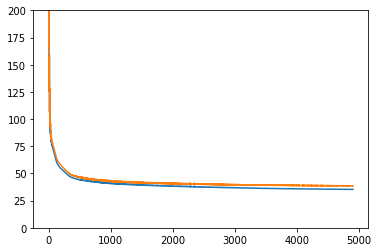

Train original rmse  39.25522232055664
Before Bounding Box: 24
After Bounding Box: 1
Y_ms: (0, 1)
TEST RMSE:  135.5831298828125


In [ ]:
rmse_dict = {}
n_epochs = 10000
random_selection =['2021-01-11_all.csv','2021-01-01_all.csv','2020-12-25_all.csv'
 ,'2020-11-25_all.csv','2020-12-20_all.csv']
random_selection = ['2021-01-01_all.csv']

for file in random_selection:
    # date = "2020-11-01"
    date = file[:-8]
    print(date)
    rmse_dict[date] = {}
    # cv_dict = preprocess_train_test(date, "", short = True, hour = None)
    cv_dict = train_test_valid(date, "merged/", hour = None, train_frac = 1, valid_cvs = 1, valid_frac=0.8)

    for cv in cv_dict.keys():
        sub_test = cv_dict[cv]["test"]
        x_test, y_test = sub_test[:, :3], sub_test[:, 3].flatten()
        x_test, y_test = torch.Tensor(x_test), torch.Tensor(y_test)
        for valid_cv in range(len(cv_dict[cv]["train"])):
            sub_train = cv_dict[cv]["train"][valid_cv]
            sub_valid = cv_dict[cv]['valid'][valid_cv]
            x_train, y_train = sub_train[:, :3], sub_train[:, 3].flatten()
            x_valid, y_valid = sub_valid[:, :3], sub_valid[:, 3].flatten()
            x_train, y_train = torch.Tensor(x_train), torch.Tensor(y_train)
            x_valid, y_valid = torch.Tensor(x_valid), torch.Tensor(y_valid)

            data_tuple = (x_train, y_train, x_valid, y_valid)
            
            if valid_cv==0:
                print("Train Size: {}, Validation Size: {}, Test Size: {}".format(data_tuple[0].shape[0], data_tuple[2].shape[0], x_test.shape[0]))
            ### chinmay : "end of mark"
            # start_time = datetime.now()
            model, train_rmse,test_rmse,total_time, ms = fit_model(data_tuple, n_epochs, normalizer = True, downsize_bool = True)
            x_ms, y_ms = ms

            # test
            
            test_tuple = get_sensor_test(date)
            x_test, y_test = test_tuple
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_tuple = (x_test, y_test)
            test_tuple, _, x_ms, y_ms = normalize_x(test_tuple, ms = ms)
            x_test, y_test = test_tuple
            print("Y_ms:", y_ms)

            model.eval()
            y_pred = model(x_test)
            test_rmse = evaluateRMSE(y_pred.squeeze(),y_test,y_ms)
            test_rmse = test_rmse.item()
            print("TEST RMSE: ",test_rmse)
            rmse_dict[date]["time"] = total_time  # just the train time, spent in fit function
            rmse_dict[date]["train_rmse"] = train_rmse
            rmse_dict[date]["test_rmse"] = test_rmse


In [ ]:
rough_x, rough_y = get_sensor_test(date)

Before Bounding Box: 24
After Bounding Box: 1


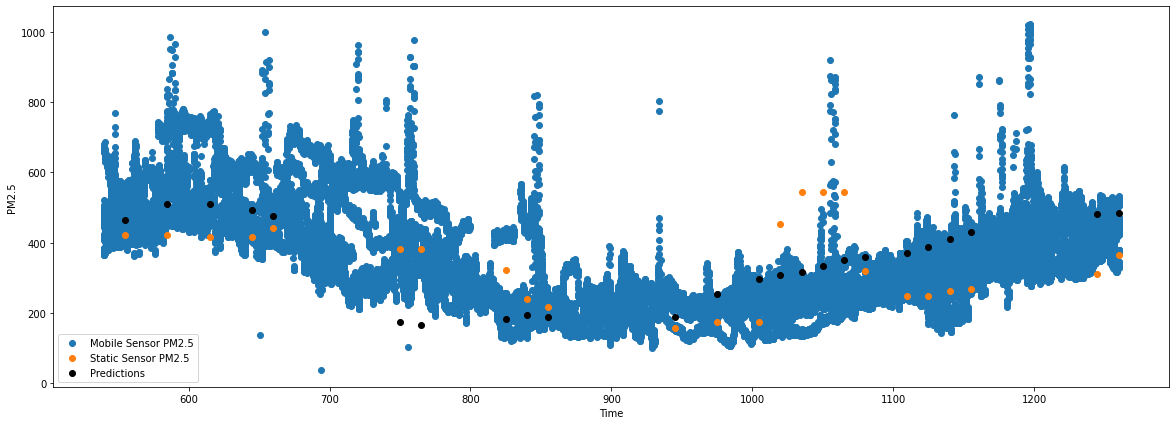

In [ ]:
plt.figure(figsize=(20,7))
plt.scatter(sub_train[:, 0], sub_train[:, -1], label="Mobile Sensor PM2.5")
plt.scatter(rough_x[:, 0], rough_y, label="Static Sensor PM2.5")
plt.scatter(rough_x[:, 0], (y_pred * y_ms[1] + y_ms[0]).cpu().detach().numpy(),
            color="black", label="Predictions")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()

In [ ]:
sub_train

array([[ 540.       ,   28.492805 ,   77.303825 ,  507.       ],
       [ 540.       ,   28.4928134,   77.303819 ,  482.       ],
       [ 540.       ,   28.492826 ,   77.30381  ,  503.       ],
       ...,
       [1260.       ,   28.644352 ,   77.316772 ,  335.       ],
       [1260.       ,   28.644482 ,   77.316818 ,  333.       ],
       [1260.       ,   28.6446165,   77.316864 ,  328.       ]])

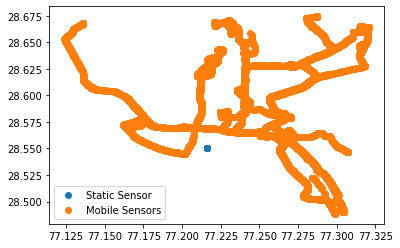

In [ ]:
plt.scatter(rough_x[:, 2], rough_x[:, 1], label="Static Sensor")
plt.scatter(sub_train[:, 2], sub_train[:, 1], label="Mobile Sensors")
plt.legend()